<p align="center">
    <img src="./images/msp_header.png">
</p>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta



# Multiresolution

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/O4m8fZHgl0c" 
    frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Uniform Filter Bank

Frequency Decomposition of a **uniform filter bank**:
<p align="center">
    <img src="./images/uniformFB.PNG">
</p>


**Example:** a spectrogram shows the amount of signal energy in each of those time/frequency rectangles (also called “tile” or “bin”). In Python a spectrogram is produced with the command “specgram” (in the pyplot library). 

In [8]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/H3EbSZ0ptpA" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Data Type: int16
Array shape: (1146600,)


<IPython.core.display.Javascript object>


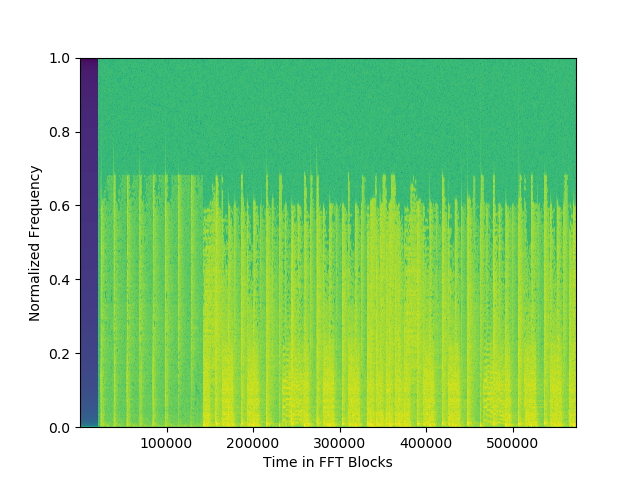

In [7]:
import scipy.io.wavfile as wav 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
rate, snd = wav.read('./audio/ACDC - Back In Black Intro.wav')
print("Data Type:", snd.dtype)
#Convert to mono
mono=np.around((snd[:,0]/2+snd[:,1]/2)).astype(np.int16)
print("Array shape:",mono.shape)   
#A spectrogram with 1024 frequency bins:
plt.specgram(mono+0.001,NFFT=1024, Fs=2)
plt.xlabel('Time in FFT Blocks')
plt.ylabel('Normalized Frequency')
plt.show()

In [3]:
import pyaudio
import struct
from numpy import clip
import numpy as np

CHUNK = 1024 #Blocksize
WIDTH = 2 #2 bytes per sample
CHANNELS = 1 #2
RATE = rate  #Sampling Rate in Hz
p = pyaudio.PyAudio()

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=False,
                output=True,
                frames_per_buffer=CHUNK)   

for i in range(0, int(len(mono) / CHUNK) ):
    #converting from short integers to a stream of bytes in data:
    samples=mono[i*CHUNK:((i+1)*CHUNK)];
    samples=clip(samples,-2**15,2**15-1)
    stream.write(samples.astype(np.int16),len(samples))   

stream.stop_stream()
stream.close()


In [4]:
import IPython.display as ipd
ipd.display(ipd.Audio('./audio/Guns N Roses-Sweet Child O Mine Intro.wav'))

Data Type: float32
Array shape: (661500,)


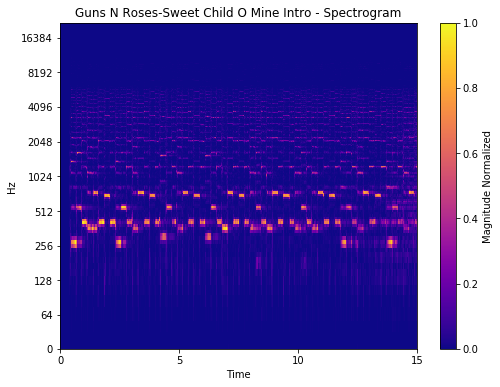

In [5]:
import librosa
import librosa.display
x, sr = librosa.load('./audio/Guns N Roses-Sweet Child O Mine Intro.wav', sr=None, mono=True)
print("Data Type:", x.dtype)
print("Array shape:",x.shape)
ipd.display(ipd.Audio(x, rate=sr))
X = np.abs(librosa.stft(x,n_fft=2048, hop_length=256))
X/=np.abs(X).max()
plt.figure(figsize=(8, 6))
plt.title('Guns N Roses-Sweet Child O Mine Intro - Spectrogram')
librosa.display.specshow(X, sr=sr, hop_length=256, x_axis='time', y_axis='log', cmap='plasma')
clb = plt.colorbar()
clb.set_label('Magnitude Normalized')

Here the color indicates the magnitude of the coefficient of the underlying FFT bin, at a given time and frequency:
 - Blue: low magnitude of the FFT coefficientss or samples.
 - Yellow: high magnitudes of the FFT coefficient or samples.
 
Observe that the size of the time/frequency bins of the FFT is independent of time or frequency.

## Python Example for a Live Spectrogram and Aliasing:

To hear how aliasing sounds if we don't take care of the Shannon-Nyquist theorem, we can run the following example.

**Observe:** You can hear high pitched artifacts in the voice. This is the aliasing and spectral copies.

In the live spectrogram you can see the aliasing as spectral copies of the original into higher frequencies.
Also observe how we can reduce the aliasing using the low pass filter. Then the higher spectral copies are attenuated, and we hear fewer artifacts.

In this example we lost the upper 14 khz of our signal. To avoid this, we use so-called filter banks, which not only use a low pass, but also band passes and a high pass.

In [12]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/2uad3fU7X30" frameborder="0" 
        allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [44]:
# Imports and Configuration

import pyaudio
import numpy as np
import scipy.signal as signal
import struct
import matplotlib.pyplot as plt
from matplotlib.mlab import window_hanning,specgram
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, MultipleLocator
from ipywidgets import ToggleButton, Checkbox, Button
from ipywidgets import HBox, interact
import threading


In [45]:
%matplotlib notebook

In [46]:
# Parameters
CHUNK_SIZE = 2048 #Blocksize
CHANNELS = 1 # Audio Channes
RATE = 32000  #Sampling Rate in Hz
N=8.0     #Downsampling/Upsampling Rate
FORMAT = pyaudio.paInt16 #conversion format for PyAudio stream
NFFT = 1024 #NFFT value for spectrogram
OVERLAP = 512 #overlap value for spectrogram

<IPython.core.display.Javascript object>


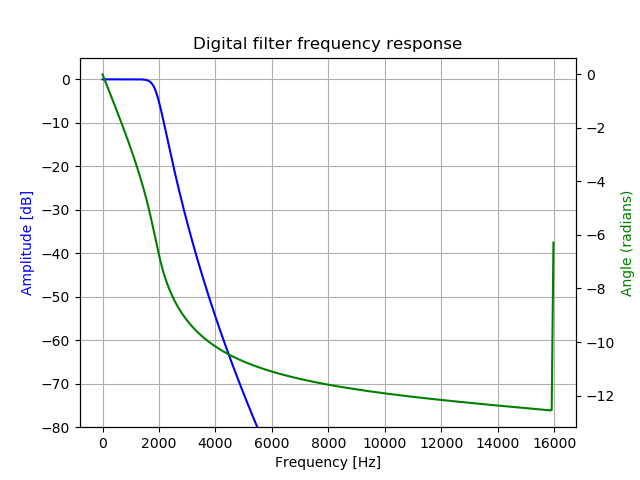

In [47]:
# LP Filter
[b,a]=signal.iirfilter(8, 1900.0/16000,rp=60,btype='lowpass')
#Memory for the filter:
zd=np.zeros(8)
zu=np.zeros(8)
LPFilterOn=False

# LP Filter Frequency Response
w, h = signal.freqz(b,a)
f = w*16000/(np.pi)
fig, ax1 = plt.subplots()
plt.title('Digital filter frequency response')
plt.plot(f, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.ylim((-80,5))
plt.grid()
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(f, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.axis('tight')
plt.show()


In [48]:
# Function to Plot Spetrogram
SamplingOn=False # Turn Donwsampling/Upsampling On/Off
ctr=0 # Control for plotting
def run_spectrogram(toggle_run):
    global zd, zu, ctr, SamplingOn, LPFilterOn
    while(True):
        if toggle_run.value==True:
            break
            
        #Reading from audio input stream into data with block length "CHUNK":
        data_stream = stream.read(CHUNK_SIZE)
        shorts = (struct.unpack( 'h' * CHUNK_SIZE, data_stream ));
        samples=np.array(list(shorts),dtype=float);

        #start block-wise signal processing:
        #Low pass filter *before downsampling*:
        if LPFilterOn==True:
            [samples,zd]=signal.lfilter(b, a, samples, zi=zd)

        #Compute a block/an array of a unit pulse train corresponding a downsampling rate of N:
        #make unit pulse train with modulus function "%": 
        s=(np.arange(0,CHUNK_SIZE)%N)==0
        #The sampling:
        #multiply the signal with the unit pulse train:
        if SamplingOn == True:
            samples=samples*s;


        #Lowpass filtering *after upsampling*:
        #filter function:
        if LPFilterOn==True:
            [samples,zu]=signal.lfilter(b, a, samples, zi=zu)

        #end signal processing

        #play out samples:
        samples=np.clip(samples, -32000,32000)
        samples=samples.astype(int)
        #converting from short integers to a stream of bytes in "data":
        data=struct.pack('h' * len(samples), *samples);
        #Writing data back to audio output stream: 
        stream.write(data, CHUNK_SIZE)

        # Update Plot
        if (ctr%4 ==0):
            arr2D,freqs,bins = specgram(samples,window=window_hanning,
                                        Fs = RATE,NFFT=NFFT,noverlap=OVERLAP)
            im_data = im.get_array()
            if ctr < 16:
                im_data = np.hstack((im_data,arr2D))
                im.set_array(im_data)
            else:
                keep_block = arr2D.shape[1]*(16 - 1)
                im_data = np.delete(im_data,np.s_[:-keep_block],1)
                im_data = np.hstack((im_data,arr2D))
                im.set_array(im_data)
            fig.canvas.draw()
        ctr+=1

In [54]:
# GUI
toggle_run = ToggleButton(description='Stop')
button_start= Button(description='Start')
box_sampling = Checkbox(False, description='Downsampling/Upsampling')
box_LPFilter = Checkbox(False, description='LP Filters')

def start_button(button_start):
    thread.start()
    button_start.disabled=True
button_start.on_click(start_button)


def on_click_toggle_run(change):
    if change['new']==False:
        stream.stop_stream()
        stream.close()
        p.terminate()
        plt.close()
toggle_run.observe(on_click_toggle_run, 'value')

def box_samping_changed(box_sampling):
    global SamplingOn
    if box_sampling['new']: 
        SamplingOn=True
    else:
        SamplingOn=False       
box_sampling.observe(box_samping_changed, names='value')

def box_LPFilter_changed(box_LPFilter):
    global LPFilterOn
    if box_LPFilter['new']: 
        LPFilterOn=True
    else:
        LPFilterOn=False       
box_LPFilter.observe(box_LPFilter_changed, names='value')

box_buttons = HBox([button_start,toggle_run])
box_checkbox = HBox([box_sampling,box_LPFilter])

In [55]:
# Create a Thread for run_spectrogram function
thread = threading.Thread(target=run_spectrogram, args=(toggle_run,))

In [56]:
# Start Audio Stream
# Create 
p = pyaudio.PyAudio()
    
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                frames_per_buffer=CHUNK_SIZE)



input_data = stream.read(CHUNK_SIZE)
samples = np.frombuffer(input_data,np.int16)

<IPython.core.display.Javascript object>


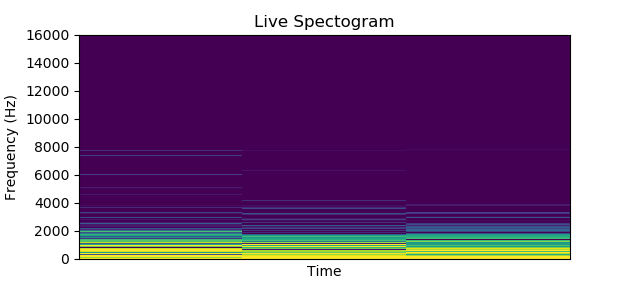

In [57]:
# Initialize Plot and Display GUI

display(box_buttons)
display(box_checkbox)

fig, ax = plt.subplots()
arr2D,freqs,bins = specgram(samples,window=window_hanning,
                                Fs = RATE,NFFT=NFFT,noverlap=OVERLAP)


extent = (bins[0],bins[-1]*32,freqs[-1],freqs[0])
im = plt.imshow(arr2D,aspect='auto',extent = extent,interpolation="none",
                     norm = LogNorm(vmin=.01,vmax=1))
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Live Spectogram')
plt.gca().invert_yaxis()
plt.xticks([])

def handle_close(evt):
    # When everything done, release the capture
    stream.stop_stream()
    stream.close()
    p.terminate()
    plt.close()
plt.connect('close_event', handle_close);

# Non-Uniform Frequency Decomposition:

In [13]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/lTy7mPKLoqE" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Example:** The so-called Discrete Wavelet Transform (DWT), the discrete time version of Wavelets, is basically a 2-band decomposition after each low pass filter, 

<p align="center">
    <img src="./images/wavelet_DWT.PNG">
</p>

This results in the following time-frequency decomposition,

<p align="center">
    <img src="./images/wavelet_decomp.PNG">
</p>

# Frequency Domain and Notation

In [14]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/lZnLJAAtDi4" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

- The sign ":=" means "defined as", for instance a:=b.
- We will use letters like t,T, f for continuous values, and n,m,k,l for discrete values.
- We will use lower case letters for time domain signals, like x(n) , and upper case letters for transform domain signals, like X(ω) or X(z) .
- We will use bold face letters to denote vectors or matrices in both time domain and transform domain, like $\textbf{x}(m)$ or $\textbf{X}(z)$.
- The conjugate complex operation is symbolized with a superscript asterisk, like $x^*(n)$.
- For transform domain signals, like X (z) , the asterisk ( $X^*(z)$ ) denotes the conjugate complex operation on their coefficients only, not on their argument z .
- The overline $\overline{X(z)}$ denotes the conjugate complex operation on the final result, meaning including the argument z. 
- E(x) is the "expectation" of x(n) , for our purposes the average of x(n).
- $\downarrow N$ Symbolizes downsampling by a factor of N. If x(n) is the signal we downsample, then we also write the downsampled signal as 
$$x_{n_0}^{\downarrow N}(m):=x(mN+n_0)$$, 
where $n_0$ is the index of the first sample we keep in the downsampling, or the “phase”, with 0⩽n0⩽N−1.
- $\uparrow N$ symbolizes upsampling by a factor of N, including insertion of the zeros. If y(m) is the signal we upsample, then we also write the upsampled signal as 
$$\begin{equation}
    y_{n_0}^{\uparrow N}(m)
    \begin{cases}
      y(m), & \text{if}\ n=mN+n_0 \\
      0, & \text{elsewhere}
    \end{cases}
  \end{equation}$$
,where $n_0$ is the index of the first non-zero sample in the upsampled signal, or the phase, with 0⩽n0⩽N−1 .



# Common Types of Frequency Transforms

### Discrete Time Fourier Transform (DTFT)

In [15]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/_Z90A_bVrRs" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

It is **time-discrete:** Our signal is sampled with sampling interval T, hence our samples only exist at the sampling  time-points $t=nT$ (with n integer) or $t=n/f_s$, with the sampling frequency $f_s=1/T$. With an infinite signal length in time we get the forward DTFT:<br>
 
$$
X(e^{j \omega} )=\sum _ {n= -\infty} ^ {\infty} x(n) e ^{-j (2 \pi f/f_s) \cdot n} =\sum _ {n= -\infty} ^{\infty} x(n) e ^{-j \omega \cdot n}
$$

where $w=2\pi f /f_s$ is the **normalized (angular) frequency**, normalized to the sampling frequency.<br>
<br>
Properties: **Continuous in frequency** (because it is not periodic in time in general) and $2\pi$ periodic in frequency.<br>

(remember: $e^{j \omega}=cos(\omega) + j sin(\omega)$, hence $e^{j (\omega+2\pi)}=e^{j \omega}$). Also for n>1 we have a $2\pi$ periodicity, even a $2\pi /n$ periodicity, which in the sum adds up to a $2\pi$ periodicity. If $w=2\pi$ then $f=f_s$ is the sampling frequency, and for $\omega=\pi$ then $f=\frac{1}{2}f_s$is half the sampling frequency, which we also call the **Nyquist Frequency**.
<br><br>
**Observe:** If one domain is **discrete,** the other domain is **periodic**!<br>
<br>
The **Inverse** Discrete Time Fourier Transform is
<br>
$$x(n)=  \frac{1} {2 \pi} \cdot \int _ {\omega=-\pi} ^\pi X(e^{j\omega}) e^{j \omega n} d \omega 
$$


A **convolution** in time becomes a multiplication in the DTFT domain:
<br>
$$
x( n )*y( n ) \rightarrow X( \omega ) \cdot Y( \omega )
$$
(remember: a convolution is defined as $$y(n)=x(n)*h(n)=\sum _{m=-\infty} ^ \infty x(m) \cdot h(n-m)$$, which is mathematically more complicated than a simple multiplication in the transform domain!)
<br>

### Discrete Fourier Transform (DFT)

In [16]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/9njAZ3fTXa8" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

It is **time-discrete** and **finite in time** with signal length of N samples, where it is assumed that beyond this signal block the signal is periodic with period N. The forward transform is defined as, 
<br>

$$
X(k) =\sum _ {n= 0}^ {N-1} x(n) e^{-j \frac{2\pi} { N} \cdot k \cdot n}$$
with the discrete frequency index $k=0,...,N-1$.<br>
We transform N samples in the time domain into N samples in the frequency domain.<br>

**Observe:** we obtain the **DFT from the DTFT** as a special case, if we take the finite length signal $x(n)$ and make it **periodic** by repeating it infinitely many times into the future and the past. Then we apply the DTFT to it, and we obtain a **discrete spectrum**, since the signal is periodic. The spectrum consists of the **fundamental frequency**, which is the inverse of the length of $x(n)$, and of its **harmonics at multiple frequencies of the fundamental frequency**. The coefficients of these frequencies are output of the DFT.<br>
In **Python:**<br>

```scipy.fftpack.fft(..)```<br>
<br>

**Properties: Discrete in frequency**, because of finite extend in time, **periodic in time**. Hence the frequency index is now k and an integer number between 0 and N-1. It is periodic in frequency, with period N, because it is discrete in time (k=N corresponds to the normalized frequency $2\pi$, our sampling frequency). <br>

Its **inverse transform** is:<br>
$$
x(n) = \frac{1}{ N} \sum _ {k= 0} ^ {N-1} X(k) e ^{j \frac{2\pi} {N} \cdot k \cdot n}
$$<br>
In **Python:**<br>
```scipy.fftpack.ifft(..)```<br>

Since the DFT assumes the signal to be **periodic** with period N, the convolution of this periodic signal, called **circular convolution**, becomes a multiplication in the DFT domain.<br>
$$
x( n ) *_c y( n ) \rightarrow X( \omega ) \cdot Y( \omega )
$$

where the circular convolution is
<br>
$$
x( n ) *_c y( n ) :=\sum _ {n'=0} ^ {N-1} x( n' ) \cdot y( (n-n')\text {mod N} )
$$
where $mod$ is the Modulus function, which is the remainder after division by N, and is between 0 and N-1. Corresponds to the Python numpy function “remainder”. 
<br><br>


**Observe:** A finite/periodic signal in time leads to a discrete spectrum, and a sampled, time-discrete signal leads to a periodic spectrum. Because of the symmetry between time and frequency the same holds also the other way around (discrete frequency → periodic time, periodic frequency → discrete time).<br>

### Discrete Cosine Transform (DCT)

In [17]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/364IycaXXDE" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Another widely used block transform is the Discrete Cosine Transform. The so-called **DCT Type 4** is defined as<br>

$$
y_k(m)=\sqrt{\frac{2}{ N}} \sum _ {n=0}^ {N-1} x(mN+n) \cdot  cos \left(\frac{\pi} {N} (n+0.5)(k+0.5) \right)
$$
for the analysis (k=0,...,N-1). Characteristic here is the shift of 0.5 in the subband index k and the time index n. Observe the index m, it is the block index, used for processing streams.<br><br>
In **Python:**<br>
```scipy.fftpack.dct(..,norm='ortho')```<br>
Unfortunately, the fftpack only has the dct types 1 to 3, and not 4. The type 4 can be obtained using the type 3.<br>
For instance:

In [ ]:
def DCT4(samples):
    """samples : (1D Array) Input samples    
     to be transformed
     Returns:y (1D Array) Transformed  
    output samples
    """
    import numpy as np
    import scipy.fftpack as spfft
    N=len(samples)
    # Initialize
    samplesup=np.zeros(2*N)
    # Upsample signal:
    samplesup[1::2]=samples      
    y = spfft.dct(samplesup,type=3,
    norm='ortho')*np.sqrt(2)
    return y[0:N]

The **inverse DCT 4** transform is
<br>
$$
x(mN+n)=\sqrt{\frac{2}{ N}} \sum _{k=0} ^ {N-1} y_k(m) \cdot  cos \left(\frac{\pi}{N} (n+0.5)(k+0.5) \right)
$$<br>
Observe that it is identical to the forward transform. In general, the DCT-4 inverse is identical to its forward transform, but up to a factor. If this factor is 1, then it is an “orthonormal” transform. The python function needs an argument norm=’ortho’ for this property.<br><br> 
In **Python:**<br>

```scipy.fftpack.idct(..,norm='ortho')```<br>
again, type 4 can be obtained using type 3, and is the **same function** as the forward transform.<br><br>

Also observe: The DCT provides twice the subband “density” compared to the DFT, the frequency distance between 2 neighboring subbands is only half as much as for the DFT, which can be seen at the factor of $\pi/N$ instead of $2\pi/N$ at the DFT.
<br>


### The z-Transform

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/L9e4DrvX-lw" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Recall that the Discrete Time Fourier Transform is:
<br>

$$
X(e^{j\omega}) =\sum_{n=-\infty}^ \infty x(n) e^{-jn\omega}$$
In reduced notation:
<br>
$$
X({\omega}) = \sum _ {n=-\infty} ^\infty x(n) e^{-jn\omega}
$$

Observe that the expression $e^{j\omega}$ is a complex number on the unit circle on the complex plane. We can replace it  by a more general complex number z, which does not need to be on the unit circle, and obtain the **z-transform**:<br>
$$
X(z) = \sum _ {n=-\infty}^ \infty x(n) z^{-n}
$$
<br>
**Observe:** The z-transform simply turns a **sequence** into a **polynomial!**<br>
In **Python** for the z-transform of a finite length sequence $x(n)$ is:<br>

```z=sympy.symbols('z')```<br>
```xz=sympy.Poly(np.flipud(x), z**(-1))```<br>

The z-transform is more powerful because it is more general. Using it we can also determine, for instance, if a system or a signal has damping on it (in that case the signal would be inside the unit circle). Also, we can compute the z-transform even for unstable signals or systems (a pole outside the unit circle, exponentially growing signals), which would not be possible for the DTFT, because its sum would not converge.<br><br>
**Observe:** This is the so-called two-sided z-transform, because the time-index n is running from minus infinity to infinity, hence it already existed for an infinite time. Usually we only deal with causal signals, which start at a certain point in time, and this yields the one-sided z-transform, which starts at n=0:
<br>
$$
X(z) = \sum _ {n=0} ^ \infty x(n) z^{-n}
$$

**Convolution** in time becomes a **multiplication** in the z-domain.   <br>
$$
x(n) * y(n) \rightarrow X( z ) \cdot Y( z )
$$


**Example:** Linear Audio amplifier and an audio input signal. The frequency response of the amplifier can be H(z) or $H(\omega)$ (depending on the transform), and the frequency response or spectrum of the signal would be X(z) or $X(\omega)$. The output of the amplifier would be Y(z)=X(z)H(z) or $Y(\omega)=X(\omega)\cdot H(\omega)$. We basically multiply the frequency components of our signal with the attenuation or gain at that frequency of the amplifier. Basically H is the frequency response of our amplifier.<br><br>

Observe that **unlike a convolution** in the time domain, we can **invert the multiplication** in the frequency domain. This is a principle that is used for instance for equalizers, who try to flatten the amplifier frequency response by having a frequency response which is inverse to the frequency response of the amplifier (at each frequency bin).<br><br>

The **inverse** $z$ -transform is
<br>
$$
x(n)=\frac{1}{2\pi j}\oint_c X(z) z^{n-1} dz
$$

where $C$ is a closed contour in the complex z-plane which contains all poles of $X(z)$ in its inside, and its path is followed counter-clockwise in the mathematically positive sense.<br><br>

If we have a causal, stable z-transform $X(z)$ then all poles are inside the unit circle, hence our contour $C$ can be the unit circle around the origin, and we can set $z=e^{j\omega}$ for $0\leq \omega \leq 2\pi$. We can now apply an integration variable substitution
<br>
$$
\frac{dz}{d\omega}=j e^{j \omega}
$$
$$\rightarrow dz=d\omega \cdot j e^{j\omega}$$<br> 
(using the so-called Leibnitz notation).<br>
Now the contour integral becomes
<br>

$$
x(n)=\frac{1}{2\pi j} \oint_c  X(z) z^{n-1} dz$$
<br>
$$
x(n)=\frac{1}{2\pi j} \int_{\omega=0}^{2\pi} X(e^{j \omega}) e^{j \omega (n-1)} d\omega \cdot j  e^{j \omega}
$$
<br>

$$
=\frac{1} {2\pi} \int_{\omega=0}^{2\pi} X(e^{j \omega}) e^{j \omega n} d\omega 
$$
<br>
Now we can see that the last line is **identical** to the **inverse DTFT**, which means that for **causal stable** signals or systems the inverse z-transform becomes identical to the inverse DTFT.<br><br>
**Observe:** Finte length sequences are always causal and stable, hence their inverse z-Transform becomes the inverse DTFT, which is the **coefficients** of the z-Transform **polynomial**.<br><br>
Inverse z-tramsform for finite length sequences in **Python**:<br>
```y=np.flipud(yz.coeffs())```<br>


**Observe** that we have transform pairings of:<br>

- periodic time - discrete frequency, and 
- discrete time - periodic frequency.

**Observe:** In practice we always have **discrete finite signals,** which are assumed to be periodically continued into infinity. Hence our **frequency domain** will be **discrete and periodic.**<br><br>



### z-Transform Python Examples

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/n4keW_vluJA" frameborder="0" allow="accelerometer; 
    encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Example:** x(n) is an exponentially decaying function, starting at n=0 with x(0)=1, <br>
<br>$$x(n):= \begin{cases}
        \begin{split}
            0.5^n &\text{ for  n>= 0}\\ 0, & else
        \end{split}
    \end{cases}
$$<br>
$$
\rightarrow X(z)=\sum _ {n=0} ^\infty (0.5 \cdot z^{-1})^{n}= \frac{1}  {1-0.5 \cdot z^{-1}}
$$

Observe that the sum of the z-transform converges for $\mid z\mid > 0.5$. This is also called the „Region of Convergence“ (ROC).<br><br>

Here we can also see that we obtain a pole of the expression for z=0.5.
<br><br>
In this way we can also see what time signal corresponds to a pole (a exponential time function). We have a **correspondence:**<br> 
**exponential time** function- **pole** in z-domain
<br><br>
**Explanation for the geometric sum:**<br>
A geometric sum has the following form:
$$
S=\sum _ {n=0} ^ N a^n
$$
with some constant a. What is S?<br>
We apply a trick: compute a.S:<br>
$$
a \cdot S= \sum _ {n=0} ^ N a^{(n+1)}=\sum _ {n=1} ^ {N+1} a^n
$$
Now take aS-S:<br>

$$
S \cdot (a-1)=aS-S=a^{N+1}-1
$$<br><br>
$$
S=  \frac{a^{N+1}-1} {a-1}=\frac{1-a^{N+1}} {1-a}
$$
Hence we get:
<br>
$$
\sum _{n=0} ^ N (0.5 \cdot z^{-1})^{n}=\frac{1-(0.5 \cdot z^{-1})^{N+1}} {1-(0.5 \cdot z^{-1})}
$$<br>
We have $N \rightarrow \infty$ and a stable system where the magnitude or our factor is smaller than 1 (something we need for convergence, see above), and we get:<br>
$$\sum _ {n=0} ^ \infty (0.5 \cdot z^{-1})^{n}=\frac{1}  {1-(0.5 \cdot z^{-1})}$$


In [70]:
# Sympy Geometric Sum
import sympy as sp
n = sp.Symbol('n')
N = sp.Symbol('N')
z = sp.Symbol('z')
geo_sum=sp.summation((0.5*z**-1)**n, (n, 0, N))
geo_sum

Piecewise((N + 1, Eq(0.5/z, 1)), ((1 - (0.5/z)**(N + 1))/(1 - 0.5/z), True))

In [62]:
#simple example for signal sequence x and filter impulse response h:
x=[1,2,3,4]
h=[1,2]

#z-Transform, turn sequence into
# polynomial, in z-transf. Order:
#
import sympy
import numpy as np
z=sympy.symbols('z')
xz=sympy.Poly(np.flipud(x), z**(-1))
xz

Poly(4*(1/z)**3 + 3*(1/z)**2 + 2*(1/z) + 1, 1/z, domain='ZZ')

In [63]:
hz=sympy.Poly(np.flipud(h), z**(-1))
hz

Poly(2*(1/z) + 1, 1/z, domain='ZZ')

Multiplication in the z-Domain:
$$Y( z )= X( z ) \cdot H( z ) $$

In [64]:
yz=xz*hz
yz

Poly(8*(1/z)**4 + 10*(1/z)**3 + 7*(1/z)**2 + 4*(1/z) + 1, 1/z, domain='ZZ')

Inverse z-transform, turn polynomial into coefficients, in z-transf. Order (works for Finite Impulse Response systems):
<br>
$$
y(n)=\frac{1}{2\pi j}\oint_c Y(z) z^{n-1} dz$$

In [65]:
y=np.flipud(yz.coeffs())
print(y)

[1 4 7 10 8]


Convolution in time domain:
$$
x(n)*h(n)
$$


In [66]:
import numpy as np
np.convolve(x,h)

array([ 1,  4,  7, 10,  8])

**Observe:** samples after convolution are identical to polynomial coefficients after z-Transform above.<br>
But convolve is usually faster than symbolic calculation.<br>
<br>
Convolution as sum:<br>
$$
y ( n ) =x ( n ) *h ( n ) = \sum _{l=0 } ^{L-1}  x ( n - l ) \cdot h ( l )   
$$

In [67]:
Nx=len(x)
Nh=len(h)
#convolution length:
Deg=Nx+Nh-1
y=np.zeros(Deg)
#loop over convolution index:
for n in range(0,(Deg)):
    #loop over sum index:
    for l in range(0,n+1):
        #only over parts where x and y 
        #are defined:
        if ((n-l)<Nx and l<Nh):
            y[n] = y[n]+ x[(n-l)]*h[l];
print(y)

[ 1.  4.  7. 10.  8.]


**Observe:** We get again the same result as above, as expected.


### The Short-Time Fourier Transform (STFT)

In [3]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/TL9hiIGJYbg" frameborder="0" allow="accelerometer; 
encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The STFT is basically a DFT applied to short blocks of the signal. For that, the signal is first divided into overlapping blocks of length N and with “hop-size” M.<br>
The **analysis equation** is
<br>
    
$$
Y_k(m) =\sum_{n= 0} ^ {N-1} h(n) \cdot x(m \cdot M +n) e ^{-j \frac{2\pi} { N} \cdot k \cdot n}
$$    

with m=0 until the end of x again the block index, $h(n)$ and is a **window function** of length N for improved filtering properties. Assume N=LM.
<br><br>

For the synthesis the overlapped blocks are added up (overlap-add). The **synthesis equation** is
<br>

$$
\hat{x}_{m}(n) =  \frac{h(n)} { N}  \cdot \sum _{k= 0} ^ {N-1} Y_k(m) e ^{j \frac{2\pi} {N} \cdot k \cdot n}, n=0,...,N-1
$$
overlap-add:<br>
$$
x(m_0 \cdot M+n) = \sum _{m=0}^ {L-1} {\hat{ x }}_{m_0-m}(mM+ n )
$$

n=0,…,M-1.<br>

The window has the **overlap-add property**<br>
$$
\sum_{ m=0 } ^{L-1} h^2( n +mM ) =1 , n=0,...,M-1
$$
<br>

The STFT is also a **filter bank**, but with **non-critical sampling**, since usually M<N.<br><br>

In the literature the **window** function h(n) is usually only applied to the analysis part. Here we also applied it to the **synthesis** part, because this improves the resulting synthesis filters, and is more similar to usual filter banks.<br><br>
The corresponding Python function is<br>
```scipy.signal.stft```<br>

In [71]:
# Python Example
import numpy as np
import scipy
x=np.arange(32)
print('Signal:',x)
f,t,y=scipy.signal.stft(x,nperseg=4) 
#nperseg is fft length, 
#f: frequencies of fft subbands, 
#t: times of subband samples
#noverlap = nperseg // 2 ny deafult
print('Frequencies of the fft subbands :',f)
print('Times of the subband samples :',t)
print('Stft:',y)
#Inverse STFT:
t, xrec=scipy.signal.istft(y)
print('Times of reconstructed samples:',t)
print('Reconstructed samples:',xrec)
#xrec: reconstructed samples
#t: times of reconstructed samples

Signal: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Frequencies of the fft subbands : [0.   0.25 0.5 ]
Times of the subband samples : [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32.]
Stft: [[  0.25+0.j     2.  +0.j     4.  +0.j     6.  +0.j     8.  +0.j
   10.  +0.j    12.  +0.j    14.  +0.j    16.  +0.j    18.  +0.j
   20.  +0.j    22.  +0.j    24.  +0.j    26.  +0.j    28.  +0.j
   30.  +0.j     7.75+0.j  ]
 [  0.  +0.25j  -1.  +0.5j   -2.  +0.5j   -3.  +0.5j   -4.  +0.5j
   -5.  +0.5j   -6.  +0.5j   -7.  +0.5j   -8.  +0.5j   -9.  +0.5j
  -10.  +0.5j  -11.  +0.5j  -12.  +0.5j  -13.  +0.5j  -14.  +0.5j
  -15.  +0.5j    0.  -7.75j]
 [ -0.25+0.j     0.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j
    0.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j
    0.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j
    0.  +0.j    -7.75+0.j  ]]
Times of reconstructed samples: [ 0.  1.  2.  3.  4.  5.  6

<IPython.core.display.Javascript object>


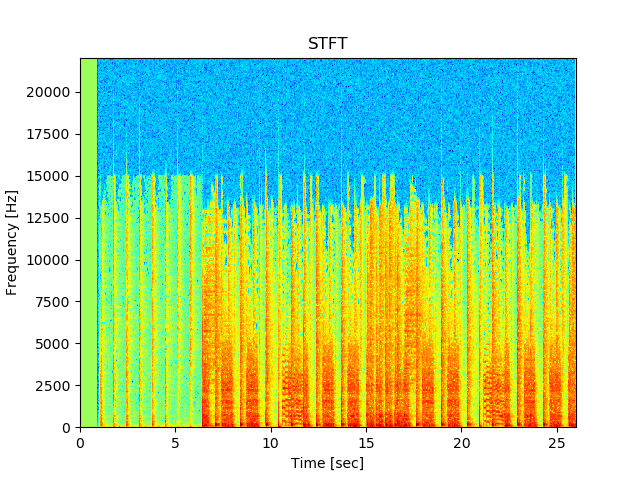

In [72]:
import scipy.io.wavfile as wav 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
rate, snd = wav.read('./audio/ACDC - Back In Black Intro.wav')
#Convert to mono
mono=np.around((snd[:,0]/2+snd[:,1]/2)).astype(np.int16)

f,t,y=signal.stft(mono,fs=rate, nperseg=1024) 
plt.pcolormesh(t, f, 10*np.log10(np.abs(y),where=np.abs(y)>0), cmap='jet')
plt.title('STFT')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()